In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import special
import numba as nb
from numba import jit

In [2]:
#First order


#Fluid velocity cartesian coordinates
def u(x,t):
    mod = np.sqrt(x[0]**2+x[1]**2)
    theta = np.arctan2(x[1],x[0])
    return -mod*np.sin(theta), mod*np.cos(theta)

#Gradient of fluid flow velocity cartesian coordinates
def ud(x,t):
    return np.array([[0, -1],[1,0]])

#Time derivative (if it exists)
def ut(x,t):
    return 0

#First order coefficient function
def alpha(n,j):
    
    appo = 0
    if n==0:
        appo=0 # no history
    if j==0:
        appo = 1
    elif 0<j<n:
        appo = (j-1)**(3/2) + (j+1)**(3/2) - 2*j**(3/2)
    elif j == n:
        appo = (n-1)**(3/2) - n**(3/2) +3/2*np.sqrt(n)
    else:
        return "Error"
    return 4/3*appo



In [3]:
# Basset case
def K1(A,vel):
    return np.identity(2)

def K2(A,fluidvel,vel):
    return np.identity(2)*0 

def define_A(b,a,f,dt):
    if a==b:
        return 0
    else:
        root_coeff = 1/np.sqrt(b-a)
        int_extrema = f[a-1]/2 + f[b-1]/2 
        int_core = 0
        for i in range(0,b-a-1):
            int_core += f[a+i]
        return np.sqrt(dt)*root_coeff*(int_extrema + int_core)      

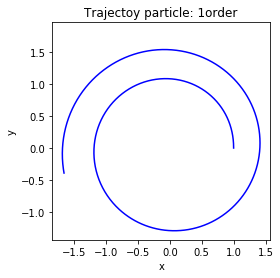

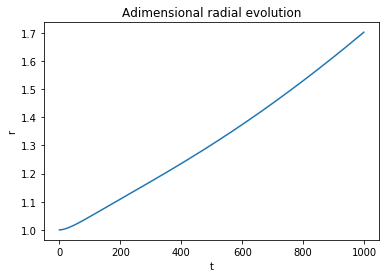

In [4]:

#Constants
Tmax= 10
dt = 0.01
steps = int(Tmax/dt)
S=0.3

gamma = 1.45
R=3/(2*gamma+1)

#Disturbance
w =np.zeros((steps,2))
w[0]=0
#(x,y) psition and radial
ps = np.zeros((steps,2))
ps[0,0]=1
r =[ps[0]]
#Particle velocity
v =np.zeros((steps,2))
v[0,0]=u(r[0],0)[0]
v[0,1]=u(r[0],0)[1]

#Weigth
epsilon = R*np.sqrt(3/math.pi*S)*dt**(1/2)

for i in range(1,steps):
    
     #Trajectory
    ps[i] = ps[i-1] + dt*(w[i-1]+u(r[i-1],i-1))
    r.append((ps[i]))    
    v[i] = w[i] +u(r[i],i)
    
    summ = 0 
    prefactor = (1/(1+alpha(i,0)*epsilon))
    
    #History force 1st order
    for j in range(0,i-1):
        summ += (alpha(i,j+1) - alpha(i-1,j))*w[i-1-j]
    
    #Coefficient for advective term
    G = (R-1)*(ut(r[i-1],i-1)+ud(r[i-1],i-1).dot(v[i-1]))\
                           -R*(ud(r[i-1],i-1).dot(w[i-1]))\
                               -R/S*w[i-1]
    
    #Disturbance computation
    w[i] = prefactor*(w[i-1] - epsilon*summ + dt*G)

   
    
plt.title('Trajectoy particle: 1order as Daitche')
plt.plot(ps[:,0],ps[:,1],'b')
plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.title('Adimensional radial evolution')
plt.plot(np.linalg.norm(r,axis=1))
plt.ylabel('r')
plt.xlabel('t')
plt.show()

In [5]:

#Vectorial disturbance flow
w =np.zeros((steps,2))
w[0]=0

#Position
pos = np.zeros((steps,2))
pos[0,0]=1
r =[pos[0]]

#Particle velocity
v =np.zeros((steps,2))
v[0,0]=u(r[0],0)[0]
v[0,1]=u(r[0],0)[1]

#Parameters
#Numer of steps
m=10
#Reynolds
Re = 1

#Strouhal
St = 0.3

#Adimensional mass
gamma = 1.45
R=3/(2*gamma+1)


#Adimensional Struhal Reynolds
S = Re*St  

#Weight
epsilon = R*np.sqrt(3/math.pi*S)*dt**(1/2)

#Coefficent for second kernel
coeff2 = np.sqrt(St/Re)

#@nb.njit(parallel=True, nogil=True, fastmath=True)
#def time_evolution(Tmax,dt):
    
#Variables
steps = int(Tmax/dt)
for i in range(1,steps):
    
     #Trajectory
    pos[i] = pos[i-1] + dt*(w[i-1] +u(r[i-1],i-1))
    r.append((pos[i]))    
    v[i] =(w[i] +u(r[i],i))

    
    #Weight for implicitness of the equation
    summ = 0
    prefactor = (1/(1+alpha(i,0)*epsilon))
    #Gli ultimi step prima di t deve farli basset

    if i-1 <= m:
        n = i-1
    else:
        n = 10
    for j in range(0,n):
        summ += (alpha(i,j+1) - alpha(i-1,j))*w[i-j-1]

    # Questo primo integrale arriva fino, diciamo t-mh
    integral1t = 0
    integral2t = 0
    
    for l in range(0,i-n-1): # Mettere n steps prima
        Al = coeff2*define_A(i,l,v,dt)
        Al0 = coeff2*define_A(i,l-1,v,dt)
        
        int1 = 1/np.sqrt((i-l))*(w[l+1]-w[l-1])/4
        #first_half_int1 = 3*np.dot(K1(Al,w),int1)
        first_half_int1 = np.dot(K1(Al,w),int1)
        
        int2 = 1/np.sqrt((i-l-1))*(w[l]-w[l-2])/4
        sec_half_int1 = np.dot(K1(Al0,w),int2)
        
        int1b = w[l]*1/np.sqrt((i-l))
        #first_half_int2 = 3*np.dot(K2(Al,u,w),int1b)
        first_half_int2 = np.dot(K2(Al,u,w),int1b)
        int2b = 1/np.sqrt((i-l))*(2*w[l]-w[l+1])
        sec_half_int2 = np.dot(K2(Al0,u,w),int2b)

        integral1t += first_half_int1 - sec_half_int1
        integral2t += first_half_int2 - sec_half_int2
        
    G = (R-1)*(ut(r[i-1],i-1)+ud(r[i-1],i-1).dot(v[i-1]))\
                           -R*(ud(r[i-1],i-1).dot(w[i-1]))\
                            -R/S*(w[i-1])
   
    #Disturbance                                             
    w[i] = prefactor*(w[i-1]  - epsilon*(summ + dt*integral1t - dt*coeff2*(integral2t))\
                     +dt*G)


    

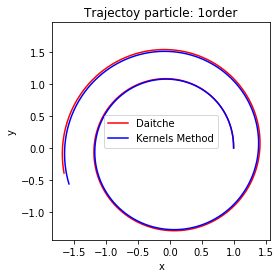

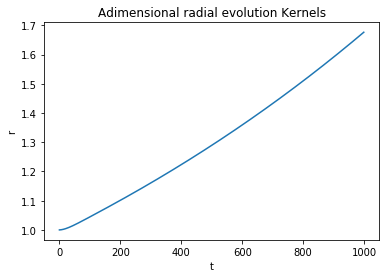

In [6]:
plt.title('Trajectoy particle: 1order')
plt.plot(ps[:,0],ps[:,1],'r',label="Daitche")
plt.plot(pos[:,0],pos[:,1],'b',label="Kernels Method")
plt.legend()
plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.title('Adimensional radial evolution Kernels')
plt.plot(np.linalg.norm(r,axis=1))
plt.ylabel('r')
plt.xlabel('t')
plt.show()


In [7]:
Tmax=5
dt=0.01
steps=int(Tmax/dt)
#Vectorial disturbance flow
w =np.zeros((steps,2))
w[0]=0

#Position
pos = np.zeros((steps,2))
pos[0,0]=1
r =[pos[0]]

#Particle velocity
v =np.zeros((steps,2))
v[0,0]=u(r[0],0)[0]
v[0,1]=u(r[0],0)[1]

#Parameters
#Numer of steps
m=10
#Reynolds
Re = 10

#Strouhal
St = 0.3

#Adimensional mass
gamma = 1.45
R=3/(2*gamma+1)


#Adimensional Struhal Reynolds
S = Re*St  

#Weight
epsilon = R*np.sqrt(3/math.pi*S)*dt**(1/2)

#Coefficent for second kernel
coeff2 = np.sqrt(St/Re)

#@nb.njit(parallel=True, nogil=True, fastmath=True)
#def time_evolution(Tmax,dt):
    
#Variables
steps = int(Tmax/dt)
for i in range(1,steps):
    
     #Trajectory
    pos[i] = pos[i-1] + dt*(w[i-1] +u(r[i-1],i-1))
    r.append((pos[i]))    
    v[i] =(w[i] +u(r[i],i))

    
    #Weight for implicitness of the equation
    summ = 0
    prefactor = (1/(1+alpha(i,0)*epsilon))
    #Gli ultimi step prima di t deve farli basset

    if i-1 <= m:
        n = i-1
    else:
        n = 10
    for j in range(0,n):
        summ += (alpha(i,j+1) - alpha(i-1,j))*w[i-j-1]

    # Questo primo integrale arriva fino, diciamo t-mh
    integral1t = 0
    integral2t = 0
    
    for l in range(0,i-n-1): # Mettere n steps prima
        Al = coeff2*define_A(i,l,v,dt)
        Al0 = coeff2*define_A(i,l-1,v,dt)
        
        int1 = 1/np.sqrt((i-l))*(w[l+1]-w[l-1])/4
        #first_half_int1 = 3*np.dot(K1(Al,w),int1)
        first_half_int1 = np.dot(K1(Al,w),int1)
        
        int2 = 1/np.sqrt((i-l-1))*(w[l]-w[l-2])/4
        sec_half_int1 = np.dot(K1(Al0,w),int2)
        
        int1b = w[l]*1/np.sqrt((i-l))
        #first_half_int2 = 3*np.dot(K2(Al,u,w),int1b)
        first_half_int2 = np.dot(K2(Al,u,w),int1b)
        int2b = 1/np.sqrt((i-l))*(2*w[l]-w[l+1])
        sec_half_int2 = np.dot(K2(Al0,u,w),int2b)

        integral1t += first_half_int1 - sec_half_int1
        integral2t += first_half_int2 - sec_half_int2
        
    G = (R-1)*(ut(r[i-1],i-1)+ud(r[i-1],i-1).dot(v[i-1]))\
                           -R*(ud(r[i-1],i-1).dot(w[i-1]))\
                            -R/S*(w[i-1])
   
    #Disturbance                                             
    w[i] = prefactor*(w[i-1]  - epsilon*(summ + dt*integral1t - dt*coeff2*(integral2t))\
                     +dt*G)


    

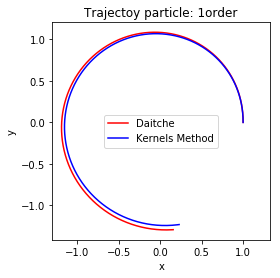

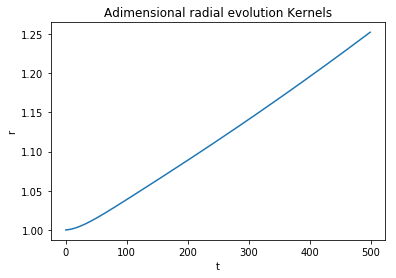

In [8]:
plt.title('Trajectoy particle: 1order')
plt.plot(ps[:500,0],ps[:500,1],'r',label="Daitche")
plt.plot(pos[:,0],pos[:,1],'b',label="Kernels Method")
plt.legend()
plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.title('Adimensional radial evolution Kernels')
plt.plot(np.linalg.norm(r,axis=1))
plt.ylabel('r')
plt.xlabel('t')
plt.show()


# Try Many Reynolds Numbers

In [9]:
Tmax=5
dt=0.01
steps = int(Tmax/dt)

#Reynolds
Re = np.array([0.05,0.5,1,2])
#vdectorial disturbance flowd
wd =np.zeros((len(Re),steps,2))
#Velocity
vd = np.zeros((len(Re),steps,2))
#Position
posd = np.zeros((len(Re),steps,2))

#Initialization
for d in range(len(Re)):
    posd[d,0,0]=1
    vd[d,0,0] = u(r[0],0)[0]
    vd[d,0,1] = u(r[0],0)[1]



#Parameters
#Numer of steps
m=10

#Strouhal
St = 0.3

#Adimensional mass
gamma = 1.45
R=3/(2*gamma+1)


#Adimensional Struhal Reynolds
S = np.zeros(len(Re))
S = [i*St for i in Re]  



for d in range(len(Re)):
    r=0
    r=[posd[d,0]]
    #wdeight
    epsilon = R*np.sqrt(3/math.pi*S[d])*dt**(1/2)
    #Coefficent for second kernel
    coeff2 = np.sqrt(St/Re[d])

    for i in range(1,steps):
    
         #Trajectory
        posd[d,i] = posd[d,i-1] + dt*(wd[d,i-1] +u(r[i-1],i-1))
        r.append((posd[d,i]))    
        vd[d,i] =(wd[d,i] +u(r[i],i))

    
        #wdeight for implicitness of the equation
        summ = 0
        prefactor = (1/(1+alpha(i,0)*epsilon))
        #Gli ultimi step prima di t devde farli basset

        if i-1 <= m:
            n = i-1
        else:
            n = 10
    
        for j in range(0,n):
            summ += (alpha(i,j+1) - alpha(i-1,j))*wd[d,i-j-1]

        # Questo primo integrale arrivda fino, diciamo t-mh
        integral1t = 0
        integral2t = 0
    
        for l in range(0,i-n-1): # Mettere n steps prima
            Al = coeff2*define_A(i,l,vd[d],dt)
            Al0 = coeff2*define_A(i,l-1,vd[d],dt)
        
        
            int1 = 1/np.sqrt(i-l)*(wd[d,l+1]-wd[d,l-1])/4

            first_half_int1 = np.dot(K1(Al,wd[d,l]),int1)
        
            int2 = 1/np.sqrt(i-l-1)*(wd[d,l]-wd[d,l-2])/4
            sec_half_int1 = np.dot(K1(Al0,wd[d,l-1]),int2)
        
            int1b = wd[d,l]*1/np.sqrt(i-l)
    
            first_half_int2 = np.dot(K2(Al,u(r[i],i),wd[d,l]),int1b)
            int2b = 1/np.sqrt((i-l))*(2*wd[d,l]-wd[d,l+1])
            sec_half_int2 = np.dot(K2(Al0,u(r[i-1],i-1),wd[d,l-1]),int2b)

            integral1t += first_half_int1 - sec_half_int1
            integral2t += first_half_int2 - sec_half_int2
        
        G = (R-1)*(ut(r[i-1],i-1)+ud(r[i-1],i-1).dot(vd[d,i-1]))\
                               -R*(ud(r[i-1],i-1).dot(wd[d,i-1]))\
                                -R/S[d]*(wd[d,i-1])
   
        #Disturbance                                             
        wd[d,i] = prefactor*(wd[d,i-1]  - epsilon*(summ + dt*integral1t - dt*coeff2*(integral2t))\
                         +dt*G)


   

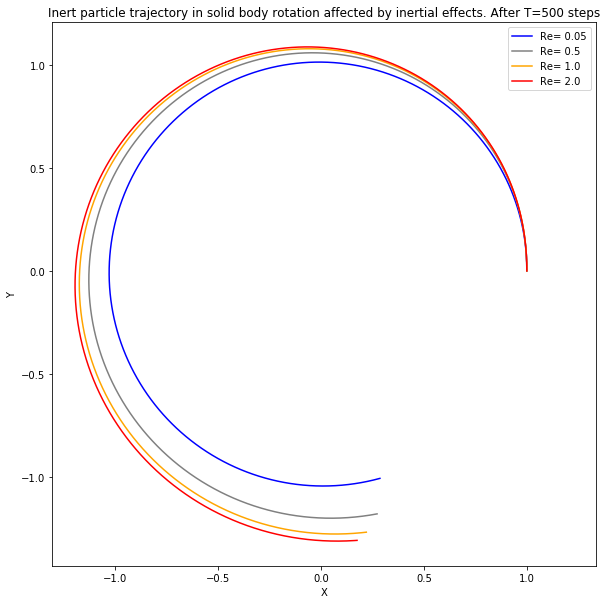

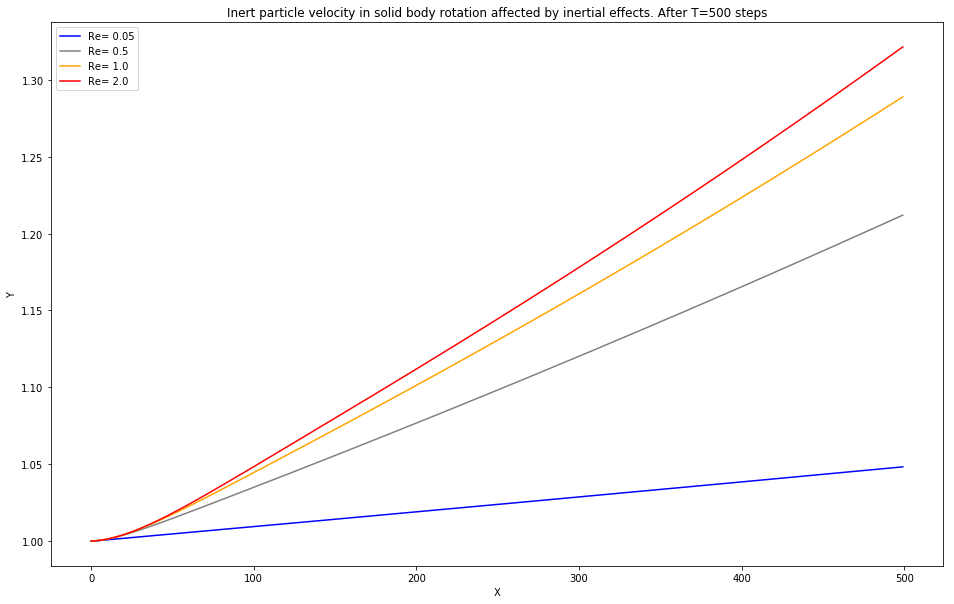

In [10]:
title = ['Re= '+str(i) for i in Re]
color = ['blue','gray','orange','red','green','black','yellow']
plt.figure(figsize=(16,10))
plt.title('Inert particle trajectory in solid body rotation affected by inertial effects. After T=' +str(steps)+' steps')
for i in range(len(Re)):
    plt.plot(posd[i,:,0],posd[i,:,1],c=color[i],label=title[i])
plt.ylabel('Y')
plt.xlabel('X')
plt.axis('square')
plt.legend()
#plt.savefig('TotalPlot.png')
plt.show()



plt.figure(figsize=(16,10))
plt.title('Inert particle velocity in solid body rotation affected by inertial effects. After T=' +str(steps)+' steps')
for i in range(len(Re)):
    plt.plot(np.arange(steps),np.linalg.norm(vd[i,:],axis=1),c=color[i],label=title[i])
plt.ylabel('Y')
plt.xlabel('X')
plt.legend()
#plt.savefig('TotalPlot.png')
plt.show()


# Try with Real Kernels

In [11]:

def K1(A,vel):
    
    if (np.linalg.norm(vel) == 0):
        return 0
    
    veldir = vel/np.linalg.norm(vel)
    pis = np.sqrt(math.pi)
    L = 3/8*((-2+1/A**2)*special.erf(A)/A -2*np.exp(-A**2)/(pis*A**2))
    M = 3/8*((1-1.5*1/A**2)*special.erf(A)/A+3*np.exp(-A**2)/(pis*A**2))
    out = np.outer(veldir,veldir)
    MATR = L*np.identity(2) + M*(np.identity(2)-out)
    return np.array(MATR)

def K2(A,fluidvel,vel):
    
    if (np.linalg.norm(vel) == 0):
        return 0
    if (np.linalg.norm(fluidvel) == 0):
        return 0
    
    veldir = vel/np.linalg.norm(vel)
    pis = np.sqrt(math.pi)
    N = 3/8*(1/2*A)*((1-1.5*1/A**2)*special.erf(A)/A+3*np.exp(-A**2)/pis*A**2)
    O = 3/8*(1/2*A)*(3*special.erf(A)/A**3-(4+6*1/A**2)*np.exp(-A**2)/pis)
    out = np.outer(veldir,veldir)
    fluiddir = fluidvel/np.linalg.norm(fluidvel)
    ins = np.outer(veldir,fluiddir)
    dot = np.dot(veldir,fluiddir)
    MATR = N*(ins - 3*dot*out) + O*dot*(np.identity(2) - out)
    return np.array(MATR)


In [12]:
#Constants
Tmax= 8
dt = 0.01
steps = int(Tmax/dt)
#Vectorial disturbance flow
w =np.zeros((steps,2))
w[0]=0

#Position
pos = np.zeros((steps,2))
pos[0,0]=1
r =[pos[0]]

#Particle velocity
v =np.zeros((steps,2))
v[0,0]=u(r[0],0)[0]
v[0,1]=u(r[0],0)[1]

#Parameters
#Numer of steps
m=10
#Reynolds
Re = 1

#Strouhal
St = 0.3

#Adimensional mass
gamma = 1.45
R=3/(2*gamma+1)


#Adimensional Struhal Reynolds
S = Re*St  

#Weight
epsilon = R*np.sqrt(3/math.pi*S)*dt**(1/2)

#Coefficent for second kernel
coeff2 = np.sqrt(St/Re)

#@nb.njit(parallel=True, nogil=True, fastmath=True)
#def time_evolution(Tmax,dt):
    
#Variables
steps = int(Tmax/dt)
for i in range(1,steps):
    
     #Trajectory
    pos[i] = pos[i-1] + dt*(w[i-1] +u(r[i-1],i-1))
    r.append((pos[i]))    
    v[i] =(w[i] +u(r[i],i))

    
    #Weight for implicitness of the equation
    summ = 0
    prefactor = (1/(1+alpha(i,0)*epsilon))
    #Gli ultimi step prima di t deve farli basset

    if i-1 <= m:
        n = i-1
    else:
        n = 10
    for j in range(0,n):
        summ += (alpha(i,j+1) - alpha(i-1,j))*w[i-j-1]

    # Questo primo integrale arriva fino, diciamo t-mh
    integral1t = 0
    integral2t = 0
    
    for l in range(0,i-n-1): # Mettere n steps prima
        Al = coeff2*define_A(i,l,v,dt)
        Al0 = coeff2*define_A(i,l-1,v,dt)
        
        int1 = 1/np.sqrt((i-l))*(w[l+1]-w[l-1])/4
        #first_half_int1 = 3*np.dot(K1(Al,w),int1)
        first_half_int1 = np.dot(K1(Al,w[l]),int1)
        
        int2 = 1/np.sqrt((i-l-1))*(w[l]-w[l-2])/4
        sec_half_int1 = np.dot(K1(Al0,w[l-1]),int2)
        
        int1b = w[l]*1/np.sqrt((i-l))
        #first_half_int2 = 3*np.dot(K2(Al,u,w),int1b)
        first_half_int2 = np.dot(K2(Al,u(r[i],i),w[l]),int1b)
        int2b = 1/np.sqrt((i-l))*(2*w[l]-w[l+1])
        sec_half_int2 = np.dot(K2(Al0,u(r[i-1],i-1),w[l-1]),int2b)

        integral1t += first_half_int1 - sec_half_int1
        integral2t += first_half_int2 - sec_half_int2
        
    G = (R-1)*(ut(r[i-1],i-1)+ud(r[i-1],i-1).dot(v[i-1]))\
                           -R*(ud(r[i-1],i-1).dot(w[i-1]))\
                            -R/S*(w[i-1])
   
    #Disturbance                                             
    w[i] = prefactor*(w[i-1]  - epsilon*(summ + dt*integral1t - dt*coeff2*(integral2t))\
                     +dt*G)


   

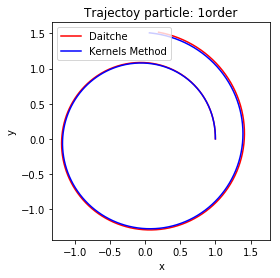

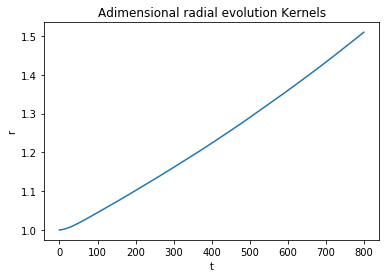

In [19]:
plt.title('Trajectoy particle: 1order')
plt.plot(ps[:800,0],ps[:800,1],'r',label="Daitche")
plt.plot(pos[:,0],pos[:,1],'b',label="Kernels Method")
plt.legend()
plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.title('Adimensional radial evolution Kernels')
plt.plot(np.linalg.norm(r,axis=1))
plt.ylabel('r')
plt.xlabel('t')
plt.show()


# Numba

In [14]:
@jit

def define_A(b,a,f,dt):
    if a==b:
        return 0
    else:
        root_coeff = 1/np.sqrt(b-a)
        int_extrema = f[a-1]/2 + f[b-1]/2 
        int_core = 0
        for i in range(0,b-a-1):
            int_core += f[a+i]
        return np.sqrt(dt)*root_coeff*(int_extrema + int_core)
#First order
def alpha(n,j):
    
    appo = 0
    if n==0:
        appo=0 # no history
    if j==0:
        appo = 1
    elif 0<j<n:
        appo = (j-1)**(3/2) + (j+1)**(3/2) - 2*j**(3/2)
    elif j == n:
        appo = (n-1)**(3/2) - n**(3/2) +3/2*np.sqrt(n)
    else:
        return "Error"
    return 4/3*appo

# Basset case
def K1(A,vel):
    return np.identity(2)

def K2(A,fluidvel,vel):
    return np.identity(2)*0 
        

#Fluid velocity cartesian coordinates
def u(x,t):
    mod = np.sqrt(x[0]**2+x[1]**2)
    theta = np.arctan2(x[1],x[0])
    return -mod*np.sin(theta), mod*np.cos(theta)

#Gradient of fluid flow velocity cartesian coordinates
def ud(x,t):
    return np.array([[0, -1],[1,0]])

#Time derivative (if it exists)
def ut(x,t):
    return 0

In [15]:
@nb.njit(parallel=True, nogil=True, fastmath=True)
#Used variables
#Variables

def time_evolution():
    Tmax= 30
    dt = 0.01
    steps = int(Tmax/dt)

    #Vectorial disturbance flow
    w =np.zeros((steps,2))
    w[0]=0

    #Position
    pos = np.zeros((steps,2))
    pos[0,0]=1
    r =[pos[0]]

    #Particle velocity
    v =np.zeros((steps,2))
    v[0,0]=0
    v[0,1]=1

    #Parameters
    #Numer of steps
    m=10
    #Reynolds
    Re = 1

    #Strouhal
    St = 0.3

    #Adimensional mass
    gamma = 1.45
    R=3/(2*gamma+1)


    #Adimensional Struhal Reynolds
    S = Re*St  

    #Weight
    epsilon = R*np.sqrt(3/math.pi*S)*dt**(1/2)

    #Coefficent for second kernel
    coeff2 = np.sqrt(St/Re)

    #@nb.njit(parallel=True, nogil=True, fastmath=True)
    #def time_evolution(Tmax,dt):

    #Variables
    steps = int(Tmax/dt)
    for i in range(1,steps):

         #Trajectory
        pos[i] = pos[i-1] + dt*(w[i-1] +u(r[i-1],i-1))
        r.append((pos[i]))    
        v[i] =(w[i] +u(r[i],i))


        #Weight for implicitness of the equation
        summ = 0
        prefactor = (1/(1+alpha(i,0)*epsilon))
        #Gli ultimi step prima di t deve farli basset

        if i-1 <= m:
            n = i-1
        else:
            n = 10
        for j in range(0,n):
            summ += (alpha(i,j+1) - alpha(i-1,j))*w[i-j-1]

        # Questo primo integrale arriva fino, diciamo t-mh
        integral1t = 0
        integral2t = 0

        for l in range(0,i-n-1): # Mettere n steps prima
         
        #DEFINE A FOR NUMBA
        
            Al0 = coeff2*define_A(i,l-1,v,dt)
            
            if i==l:
                A = 0
            else:
                root_coeff = 1/np.sqrt(i-l)
                int_extrema = v[i-1]/2 + v[l-1]/2 
                int_core = 0
                for h in range(0,i-l-1):
                    int_core += v[i+h]
                A = np.sqrt(dt)*root_coeff*(int_extrema + int_core)
            Al = coeff2*A
            
            if i==l-1:
                A0 = 0
            else:
                root_coeff = 1/np.sqrt(i-l+1)
                int_extrema = v[i-1]/2 + v[l-2]/2 
                int_core = 0
                for h in range(0,i-l-2):
                    int_core += v[i+h]
                A0= np.sqrt(dt)*root_coeff*(int_extrema + int_core)

            Al0=coeff2*A0
            
            
            
            #REST OF THE INTEGRAL
            
    
            int1 = 1/np.sqrt((i-l))*(w[l+1]-w[l-1])/4
            #first_half_int1 = 3*np.dot(K1(Al,w),int1)
            first_half_int1 = np.dot(np.identity(2),int1)

            int2 = 1/np.sqrt((i-l-1))*(w[l]-w[l-2])/4
            sec_half_int1 = np.dot(np.identity(2),int2)

            int1b = w[l]*1/np.sqrt((i-l))
            #first_half_int2 = 3*np.dot(K2(Al,u,w),int1b)
            first_half_int2 = np.dot(np.identity(2)*0 ,int1b)
            int2b = 1/np.sqrt((i-l))*(2*w[l]-w[l+1])
            sec_half_int2 = np.dot(np.identity(2)*0 ,int2b)

            integral1t += first_half_int1 - sec_half_int1
            integral2t += first_half_int2 - sec_half_int2
        array = np.array([[0, -1],[1,0]])
        G = (R-1)*0+array.dot(v[i-1])\
                               -R*(array.dot(w[i-1]))\
                                -R/S*(w[i-1])

        #Disturbance                                             
        w[i] = prefactor*(w[i-1]  - epsilon*(summ + dt*integral1t - dt*coeff2*(integral2t))\
                         +dt*G)



In [ ]:
D = np.zeros((3,10,2))

In [ ]:
D[2,0,0]=1
D[2,0,1]=1

In [ ]:
D[2,:,0]